# PCA: VIDUS vs Other HIV Acquisition Cohorts
**Author**: Jesse Marks

The VIDUS cohort has continually been an outlier set of data. Over and over, the GWAS results of VIDUS have been flipped when compared to other HIV acquisition cohorts, hence killing signal. In an attempt to assess the compatability of VIDUS with the other European ancestry HIV acquisition cohorts we will perform a principal components analysis. This will give us an opportunity to visually explore the PC relationships VIDUS has with the other cohorts. 

## Data Description
We will compare the ea-specific HIV acquisition cohorts. Their data are stored on s3 at:
* VIDUS—`s3://rti-hiv/vidus/data/genotype/observed/final/ea_chr_all.{bed,bim,fam}.gz`
* WIHS1—`s3://rti-midas-data/studies/wihs/observed/final/W14010_v01/wihs.ea.1000g.{bed,bim,fam}.gz`
* UHS1234—`s3://rti-hiv/hiv_uhs1234/data/genotype/observed/ea/ea_studies_merged.{bed,bim,fam}`

# PCA plot

In [ ]:
### PCA ###
base_dir=/shared/jmarks/sandbox/vidus_troubleshoot


## Download data ##
mkdir -p ${base_dir}/wihs_ea
cd ${base_dir}/wihs_ea
aws s3 cp s3://rti-midas-data/studies/wihs/observed/final/W14010_v01/wihs.ea.1000g.bed.gz .
aws s3 cp s3://rti-midas-data/studies/wihs/observed/final/W14010_v01/wihs.ea.1000g.bim.gz .
aws s3 cp s3://rti-midas-data/studies/wihs/observed/final/W14010_v01/wihs.ea.1000g.fam.gz .
gunzip *

mkdir -p ${base_dir}/vidus
cd ${base_dir}/vidus
aws s3 cp s3://rti-hiv/vidus/data/genotype/observed/final/ea_chr_all.bed.gz .
aws s3 cp s3://rti-hiv/vidus/data/genotype/observed/final/ea_chr_all.bim.gz .
aws s3 cp s3://rti-hiv/vidus/data/genotype/observed/final/ea_chr_all.fam.gz .
gunzip *
    
mkdir -p ${base_dir}/uhs1234_ea
cd ${base_dir}/uhs1234_ea
aws s3 cp s3://rti-hiv/hiv_uhs1234/data/genotype/observed/ea/ea_studies_merged.bed .
aws s3 cp s3://rti-hiv/hiv_uhs1234/data/genotype/observed/ea/ea_studies_merged.bim .
aws s3 cp s3://rti-hiv/hiv_uhs1234/data/genotype/observed/ea/ea_studies_merged.fam .
    
# make 1000 genomes directory structure
mkdir -p ${base_dir}/1000g

## convert SNP ids to rsIDs (not 1kg_phase3 format)
python
"""
#infile = "vidus/ea_chr_all.bim"
#outfile = "vidus/vidus_rsid.bim"
#infile = "uhs1234_ea/ea_studies_merged.bim"
#outfile = "uhs1234_ea/uhs1234_rsid.bim"
infile = "wihs_ea/wihs.ea.1000g.bim"
outfile = "wihs_ea/wihs_rsid.bim"


with open(infile, "r") as inF, open(outfile, "w") as outF:
    line = inF.readline()
    print(line)

    while line:
        sl = line.split()
        rsid = sl[1].split(":")[0]
        sl[1] = rsid
        new_line = "\t".join(sl)
        outF.write(new_line + "\n")
        line = inF.readline()
"""

# vidus
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bed ${base_dir}/vidus/ea_chr_all.bed \
    --bim ${base_dir}/vidus/vidus_rsid.bim \
    --fam ${base_dir}/vidus/ea_chr_all.fam \
    --make-bed \
    --out ${base_dir}/vidus/vidus_rsid

# uhs1234
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bed ${base_dir}/uhs1234_ea/ea_studies_merged.bed \
    --bim ${base_dir}/uhs1234_ea/uhs1234_rsid.bim \
    --fam ${base_dir}/uhs1234_ea/ea_studies_merged.fam \
    --make-bed \
    --out ${base_dir}/uhs1234_ea/uhs1234_rsid

# wihs
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bed ${base_dir}/wihs_ea/wihs.ea.1000g.bed \
    --bim ${base_dir}/wihs_ea/wihs_rsid.bim \
    --fam ${base_dir}/wihs_ea/wihs.ea.1000g.fam \
    --make-bed \
    --out ${base_dir}/wihs_ea/wihs_rsid


## Generate list of SNPs in known high-LD regions ##
perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' \
    ${base_dir}/vidus/vidus_rsid.bim  > ${base_dir}/vidus/high_ld_regions.remove

## Remove SNPs in known high-LD regions ##
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile ${base_dir}/vidus/vidus_rsid \
    --exclude ${base_dir}/vidus/high_ld_regions.remove \
    --make-bed \
    --out ${base_dir}/vidus/vidus.dbsnp138.b37.high_ld

## LD prune per chromosome ##
for chr in {1..23}; do
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name vidus_ld_prune \
        --script_prefix ${base_dir}/vidus/${chr}_ld_prune \
        --mem 3.5 \
        --nslots 2 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3500 \
            --bfile ${base_dir}/vidus/vidus.dbsnp138.b37.high_ld \
            --indep-pairwise 1500 150 0.2 \
            --chr ${chr} \
            --out ${base_dir}/vidus/chr${chr}.ld_pruned
done


## Create LD pruned PLINK file sets ##
# Merge *prune.in files
cat ${base_dir}/vidus/chr*.ld_pruned.prune.in > \
    ${base_dir}/vidus/chr_all.ld_pruned.prune.in

# Create new PLINK filesets with only ld pruned variants
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile  ${base_dir}/vidus/vidus.dbsnp138.b37.high_ld \
    --extract ${base_dir}/vidus/chr_all.ld_pruned.prune.in \
    --make-bed \
    --out ${base_dir}/vidus/vidus.dbsnp138.b37.high_ld.ld_pruned
# "133486 variants and 941 people pass filters and QC."

## Clean up
rm ${base_dir}/vidus/*ld_pruned.{prune.in,prune.out,log}
rm ${base_dir}/vidus/*qsub*
rm ${base_dir}/vidus/*high_ld_regions*
rm ${base_dir}/vidus/*nosex

## Get sorted list of all 1000G variants
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name kg.sorted.list \
    --script_prefix ancestry_partition_chr${chr} \
    --mem 5 \
    --nslots 2 \
    --priority 0 \
    --program "cat /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr{1..22}.bim | cut -f2 |
    grep rs | sort > ${base_dir}/1000g/1000g.all_variant_ids.sorted "
    
## Get list of all VIDUS ld_pruned variants
cut -f2 ${base_dir}/vidus/vidus.dbsnp138.b37.high_ld.ld_pruned.bim >\
    ${base_dir}/vidus/vidus.pruned_variant_ids
    
## Get list of all WIHS1_EA variants
cut -f2 ${base_dir}/wihs_ea/wihs_rsid.bim  >\
    ${base_dir}/wihs_ea/wihs.ea.variants

## Get list of all UHS1234_EA variants
cut -f2 ${base_dir}/uhs1234_ea/uhs1234_rsid.bim  >\
    ${base_dir}/uhs1234_ea/uhs1234.ea.variants

## Get variant intersection of VIDUS, UHS, and WIHS (overlap.sh script)
base_dir=/shared/jmarks/sandbox/vidus_troubleshoot
cat ${base_dir}/vidus/vidus.pruned_variant_ids \
    ${base_dir}/wihs_ea/wihs.ea.variants \
    ${base_dir}/uhs1234_ea/uhs1234.ea.variants  \
    ${base_dir}/1000g/1000g.all_variant_ids.sorted | \
    sort | uniq -dc | awk '$1==4 { print $2}' >\
    ${base_dir}/vidus.wihs.uhs.1000g.overlap.variants

/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name overlap \
    --script_prefix overlap \
    --mem 5 \
    --nslots 2 \
    --program bash overlap.sh


## create 1000g binary filesets with overlap snps
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name chr${chr}_filter \
        --script_prefix ${base_dir}/1000g/1000g.ld_pruned.chr$chr \
        --mem 5 \
        --nslots 2\
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink  \
            --noweb \
            --memory 10000 \
            --bfile /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
            --extract ${base_dir}/vidus.wihs.uhs.1000g.overlap.variants \
            --make-bed \
            --out ${base_dir}/1000g/1000g.chr$chr.ld_pruned
done

## merge 1000g ld_pruned autosomes
touch ${base_dir}/1000g/autosome_merge_list.txt
for chr in {1..22};do
   echo "${base_dir}/1000g/1000g.chr${chr}.ld_pruned" >>\
        ${base_dir}/1000g/autosome_merge_list.txt
done

# attempt merge
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name merge_plink_filesets \
    --script_prefix ${base_dir}/1000g/merge_plink_filesets \
    --mem 4 \
    --nslots 2\
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 4000 \
        --merge-list ${base_dir}/1000g/autosome_merge_list.txt \
        --snps-only just-acgt \
        --make-bed \
        --out ${base_dir}/1000g/1000g.chr_all.ld_pruned

# removed those multi-allelic variants
for chr in {1..22}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 4000 \
        --bfile 1000g.chr$chr.ld_pruned \
        --exclude ${base_dir}/1000g/1000g.chr_all.ld_pruned-merge.missnp \
        --snps-only just-acgt \
        --make-bed \
        --out 1000g.chr$chr.ld_pruned.removed_mssnp
done

# make new merge list
touch ${base_dir}/1000g/autosome_merge_list2.txt
for chr in {1..22};do
   echo "${base_dir}/1000g/1000g.chr${chr}.ld_pruned.removed_mssnp" >>\
        ${base_dir}/1000g/autosome_merge_list2.txt
done

# attempt 2nd merge
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name merge_plink_filesets \
    --script_prefix ${base_dir}/1000g/merge_plink_filesets \
    --mem 4 \
    --nslots 2\
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 4000 \
        --merge-list ${base_dir}/1000g/autosome_merge_list2.txt \
        --snps-only just-acgt \
        --make-bed \
        --out ${base_dir}/1000g/1000g.chr_all.ld_pruned

## filter study data to the variants that overlap with 1000g + other cohorts
# VIDUS
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ${base_dir}/vidus/vidus_rsid \
    --extract ${base_dir}/vidus.wihs.uhs.1000g.overlap.variants \
    --make-bed \
    --out ${base_dir}/vidus/vidus_all_overlap

# WIHS
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ${base_dir}/wihs_ea/wihs_rsid \
    --extract ${base_dir}/vidus.wihs.uhs.1000g.overlap.variants \
    --make-bed \
    --out ${base_dir}/wihs_ea/wihs_all_overlap

# UHS
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ${base_dir}/uhs1234_ea/uhs1234_rsid \
    --extract ${base_dir}/vidus.wihs.uhs.1000g.overlap.variants \
    --make-bed \
    --out ${base_dir}/uhs1234_ea/uhs1234_all_overlap

## combine VIDUS with other cohorts + 1000G
mkdir ${base_dir}/combined

## create merge list (note we are not including WIHS)
touch ${base_dir}/combined/study_merge_list.txt
echo -e "${base_dir}/1000g/1000g.chr_all.ld_pruned" >>\
    ${base_dir}/combined/study_merge_list.txt
echo -e "${base_dir}/vidus/vidus_all_overlap" >>\
    ${base_dir}/combined/study_merge_list.txt
echo "${base_dir}/uhs1234_ea/uhs1234_all_overlap" >>\
    ${base_dir}/combined/study_merge_list.txt

## Attempt merge 1000g with study data
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --merge-list ${base_dir}/combined/study_merge_list.txt \
    --snps-only just-acgt \
    --make-bed \
    --out ${base_dir}/combined/vidus.uhs.1000g.merged
# "Error: 5 variants with 3+ alleles present."
# note with WIHS it was like 7500!


## Exclude ambiguous snps (polymorphic) from study data
# VIDUS
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ${base_dir}/vidus/vidus_all_overlap \
    --exclude  ${base_dir}/combined/vidus.uhs.1000g.merged-merge.missnp \
    --make-bed \
    --out ${base_dir}/vidus/vidus_all_overlap2

# WIHS
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ${base_dir}/wihs_ea/wihs_all_overlap \
    --exclude  ${base_dir}/combined/vidus.uhs.1000g.merged-merge.missnp \
    --make-bed \
    --out ${base_dir}/wihs_ea/wihs_all_overlap2

# UHS
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ${base_dir}/uhs1234_ea/uhs1234_all_overlap \
    --exclude  ${base_dir}/combined/vidus.uhs.1000g.merged-merge.missnp \
    --make-bed \
    --out ${base_dir}/uhs1234_ea/uhs1234_all_overlap2

# 1000G
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ${base_dir}/1000g/1000g.chr_all.ld_pruned \
    --exclude  ${base_dir}/combined/vidus.uhs.1000g.merged-merge.missnp \
    --make-bed \
    --out ${base_dir}/1000g/1000g.chr_all.ld_pruned2

## create new merge list (note we are not including WIHS)
touch ${base_dir}/combined/study_merge_list.txt
echo -e "${base_dir}/1000g/1000g.chr_all.ld_pruned2" >>\
    ${base_dir}/combined/study_merge_list.txt
echo -e "${base_dir}/vidus/vidus_all_overlap2" >>\
    ${base_dir}/combined/study_merge_list.txt
echo "${base_dir}/uhs1234_ea/uhs1234_all_overlap2" >>\
    ${base_dir}/combined/study_merge_list.txt

## retry merge
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --merge-list ${base_dir}/combined/study_merge_list.txt \
    --snps-only just-acgt \
    --make-bed \
    --out ${base_dir}/combined/vidus.uhs.1000g.merged
# No issues

## Get 1000G superpopulation subject IDs by ancestry
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="European"){print $1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > ${base_dir}/combined/1000g_subject_IDs.EUR
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="African"){print $1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > ${base_dir}/combined/1000g_subject_IDs.AFR
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="East Asian"){print $1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > ${base_dir}/combined/1000g_subject_IDs.EAS

## exclude all other IDS except EUR, AFR, & EAS group, and VIDUS and UHS
paste *EUR *EUR > keep_ids
paste *AFR *AFR >> keep_ids
paste *EAS *EAS >> keep_ids
cut -d " "  -f1,2 ../vidus/ea_chr_all.fam >> keep_ids
cut -d " "  -f1,2 ../uhs1234_ea/ea_studies_merged.fam >> keep_ids
"""
ww keep_ids
6268 keep_ids
"""


/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile ${base_dir}/combined/vidus.uhs.1000g.merged \
    --keep keep_ids \
    --snps-only just-acgt \
    --make-bed \
    --out ${base_dir}/combined/vidus.uhs.1000g.merged.removed_other_ancestries

## Rename subject IDs if they are too long
awk '{ if(length($1)+length($2)>39){print $2} }' ${base_dir}/combined/vidus.uhs.1000g.merged.removed_other_ancestries.fam | wc -l
# 2834, therefore we will rename the IDs

awk '{$1="ID_"NR; $2="ID_"NR; print $0}' ${base_dir}/combined/vidus.uhs.1000g.merged.removed_other_ancestries.fam >\
    ${base_dir}/combined/vidus.uhs.1000g.merged.removed_other_ancestries.renamed.fam

awk '{ if(length($1)+length($2)>39){print $2} }' ${base_dir}/combined/vidus.uhs.1000g.merged.removed_other_ancestries.renamed.fam | wc -l
# 0


## Run smartpca ##
mkdir ${base_dir}/results

sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name vidus.1KG.smartpca \
    --script_prefix ${base_dir}/results/smartpca \
    --mem 13.5 \
    --nslots 7 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i ${base_dir}/combined/vidus.uhs.1000g.merged.removed_other_ancestries.bed \
        -a ${base_dir}/combined/vidus.uhs.1000g.merged.removed_other_ancestries.bim \
        -b ${base_dir}/combined/vidus.uhs.1000g.merged.removed_other_ancestries.renamed.fam \
        -o ${base_dir}/results/vidus.uhs.1000g.ld_pruned.pca \
        -p ${base_dir}/results/vidus.uhs.1000g.ld_pruned.plot \
        -e ${base_dir}/results/vidus.uhs.1000g.ld_pruned.eval \
        -l ${base_dir}/results/vidus.uhs.1000g.ld_pruned.pca.log \
        -m 0

## determine which ids are for which cohorts
awk '{$1="ID_"NR; print $0}' ${base_dir}/combined/vidus.uhs.1000g.merged.removed_other_ancestries.fam >\
    ${base_dir}/combined/partial.renamed.fam
"""
ww partial.renamed.fam
5632 partial.renamed.fam
"""
cut -d " "  -f1 ${base_dir}/vidus/ea_chr_all.fam > vidus.fam.ids
cut -d " "  -f1 ${base_dir}/uhs1234_ea/uhs1234_rsid.fam > uhs.fam.ids

# 1000G
grep -f 1000g_subject_IDs.EUR ${base_dir}/combined/partial.renamed.fam |\
    cut -d " " -f1 > 1000g.EUR.fam.ids.final
grep -f 1000g_subject_IDs.EAS ${base_dir}/combined/partial.renamed.fam |\
    cut -d " " -f1 > 1000g.EAS.fam.ids.final
grep -f 1000g_subject_IDs.AFR ${base_dir}/combined/partial.renamed.fam |\
    cut -d " " -f1 > 1000g.AFR.fam.ids.final

# VIDUS
grep -f ${base_dir}/combined/vidus.fam.ids ${base_dir}/combined/partial.renamed.fam |\
    cut -d " " -f1 > vidus.fam.ids.final

## lookup results
# vidus
grep -f ${base_dir}/combined/vidus.fam.ids.final \
    ${base_dir}/results/vidus.uhs.1000g.ld_pruned.pca.evec \
    > ${base_dir}/results/vidus.uhs.1000g.ld_pruned.pca.evec.VIDUS &
# uhs
awk 'NR==FNR {map[$1]=1;next } \
    {split($1,a,":")} \
    {if(map[a[1]]==1) {print $0}}' \
    ${base_dir}/combined/uhs.fam.ids.final \
    ${base_dir}/results/vidus.uhs.1000g.ld_pruned.pca.evec >\
    ${base_dir}/results/vidus.uhs.1000g.ld_pruned.pca.evec.UHS 


# 1KG EUR
grep -f ${base_dir}/combined/1000g.EUR.fam.ids.final \
    ${base_dir}/results/vidus.uhs.1000g.ld_pruned.pca.evec >\
    ${base_dir}/results/vidus.uhs.1000g.ld_pruned.pca.evec.EUR 
# 1KG EAS
grep -f ${base_dir}/combined/1000g.EAS.fam.ids.final \
    ${base_dir}/results/vidus.uhs.1000g.ld_pruned.pca.evec >\
    ${base_dir}/results/vidus.uhs.1000g.ld_pruned.pca.evec.EAS 
# 1KG AFR
grep -f ${base_dir}/combined/1000g.AFR.fam.ids.final \
    ${base_dir}/results/vidus.uhs.1000g.ld_pruned.pca.evec >\
    ${base_dir}/results/vidus.uhs.1000g.ld_pruned.pca.evec.AFR 

In [ ]:
## download to local
cd /cygdrive/c/Users/jmarks/Desktop/Projects/HIV/vidus/troubleshooting/pca/20190624
scp -i ~/.ssh/gwas_rsa ec2-user@34.206.166.72:/shared/jmarks/sandbox/vidus_troubleshoot/results/*evec* .
"""
vidus.uhs.1000g.ld_pruned.pca.evec                                                                                   100%  864KB 777.3KB/s   00:01
vidus.uhs.1000g.ld_pruned.pca.evec.AFR                                                                               100%  101KB 645.0KB/s   00:00
vidus.uhs.1000g.ld_pruned.pca.evec.EAS                                                                               100%   77KB 741.1KB/s   00:00
vidus.uhs.1000g.ld_pruned.pca.evec.EUR                                                                               100%   77KB 904.0KB/s   00:00
vidus.uhs.1000g.ld_pruned.pca.evec.UHS                                                                               100%  463KB 736.9KB/s   00:00
vidus.uhs.1000g.ld_pruned.pca.evec.VIDUS                                                                             100%  144KB 776.2KB/s   00:00
"""

### PCA plot in python

In [26]:
import pandas as pd
import matplotlib.pyplot as mpl

import os

os.chdir("/Users/jmarks/OneDrive - Research Triangle Institute/Projects//HIV/vidus/troubleshooting/pca/20190624")
r = os.listdir()
print(r)

def read_evec(file):
    df = pd.read_csv(file, header=None, index_col=0, sep='\s+')
    df.columns = ["PC{}".format(i) for i in range(1, 12)]
    df.index.name = "subjects"
    return df

def plot_pc(pc1, pc2, df, group, color):
    mpl.scatter(x=df[pc1], y=df[pc2], color=color, label=group)
    mpl.legend()
    mpl.xlabel(pc1)
    mpl.ylabel(pc2)


def multi_plot(plot_num, pc1, pc2):
    mpl.figure(plot_num)
    plot_pc(pc1, pc2, vidus, "VIDUS", "black")
    plot_pc(pc1, pc2, uhs, "UHS1–4", "purple")
    plot_pc(pc1, pc2, eur, "EUR", "green")
    plot_pc(pc1, pc2, afr, "AFR", "yellow")
    plot_pc(pc1, pc2, eas, "EAS", "grey")
    

eur = read_evec(file="vidus.uhs.1000g.ld_pruned.pca.evec.EUR")
vidus = read_evec(file="vidus.uhs.1000g.ld_pruned.pca.evec.VIDUS")
uhs = read_evec(file="vidus.uhs.1000g.ld_pruned.pca.evec.UHS")
afr = read_evec(file="vidus.uhs.1000g.ld_pruned.pca.evec.AFR")
eas = read_evec(file="vidus.uhs.1000g.ld_pruned.pca.evec.EAS")

print(afr.tail())
print(eur.tail())
print(eas.tail())
print(uhs.tail())
print(vidus.tail())

['README', 'vidus.uhs.1000g.ld_pruned.pca.evec', 'vidus.uhs.1000g.ld_pruned.pca.evec.AFR', 'vidus.uhs.1000g.ld_pruned.pca.evec.EAS', 'vidus.uhs.1000g.ld_pruned.pca.evec.EUR', 'vidus.uhs.1000g.ld_pruned.pca.evec.UHS', 'vidus.uhs.1000g.ld_pruned.pca.evec.VIDUS']
                    PC1     PC2     PC3     PC4     PC5     PC6     PC7  \
subjects                                                                  
ID_5521:ID_5521 -0.0307  0.0089 -0.0033  0.0013  0.0026 -0.0039  0.0069   
ID_5522:ID_5522 -0.0323  0.0088 -0.0006 -0.0049  0.0044  0.0015  0.0147   
ID_5523:ID_5523 -0.0268  0.0075 -0.0006 -0.0094  0.0018 -0.0017  0.0183   
ID_5524:ID_5524 -0.0267  0.0077 -0.0022 -0.0064 -0.0019 -0.0032  0.0156   
ID_5525:ID_5525 -0.0266  0.0076 -0.0104  0.0009  0.0006 -0.0097  0.0199   

                    PC8     PC9    PC10 PC11  
subjects                                      
ID_5521:ID_5521  0.0048 -0.0009 -0.0106  ???  
ID_5522:ID_5522  0.0001 -0.0060 -0.0001  ???  
ID_5523:ID_5523 -0.0089 -

<IPython.core.display.Javascript object>


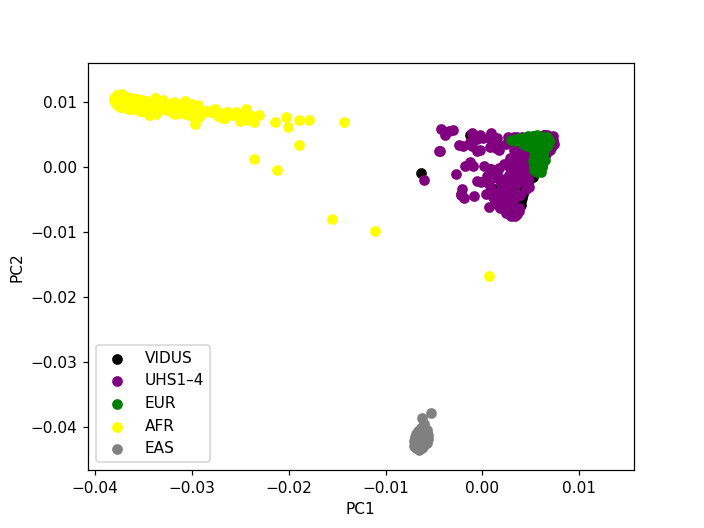

<IPython.core.display.Javascript object>


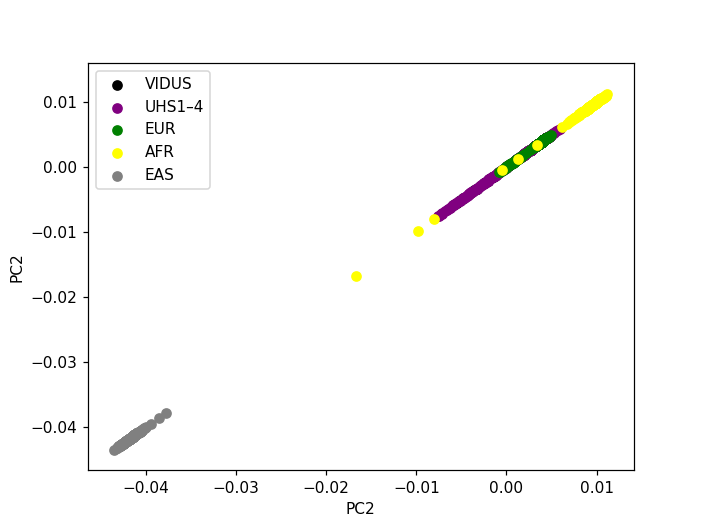

<IPython.core.display.Javascript object>


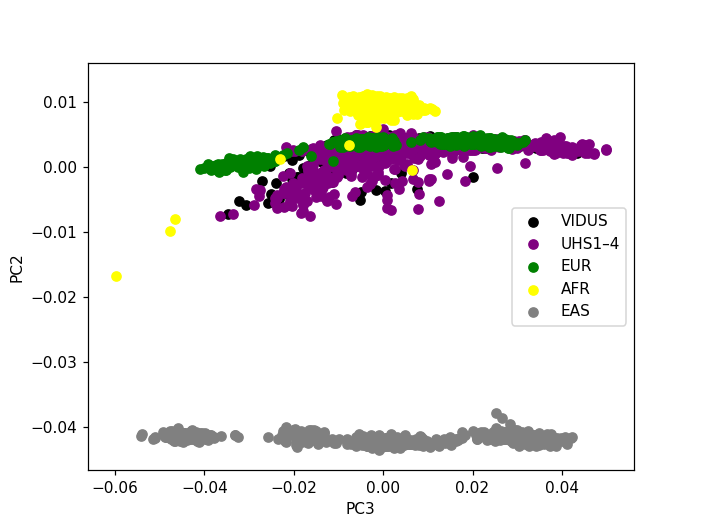

<IPython.core.display.Javascript object>


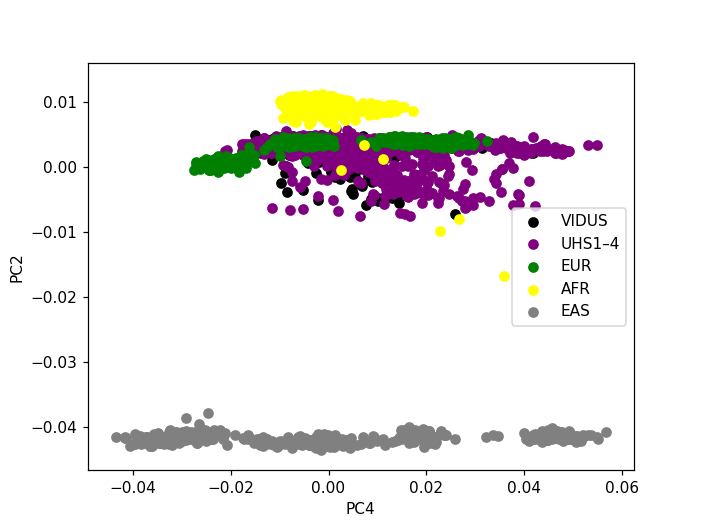

<IPython.core.display.Javascript object>


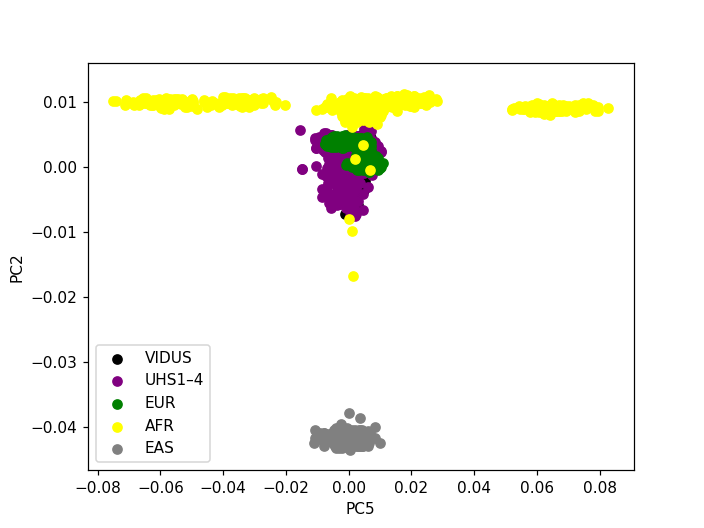

<IPython.core.display.Javascript object>


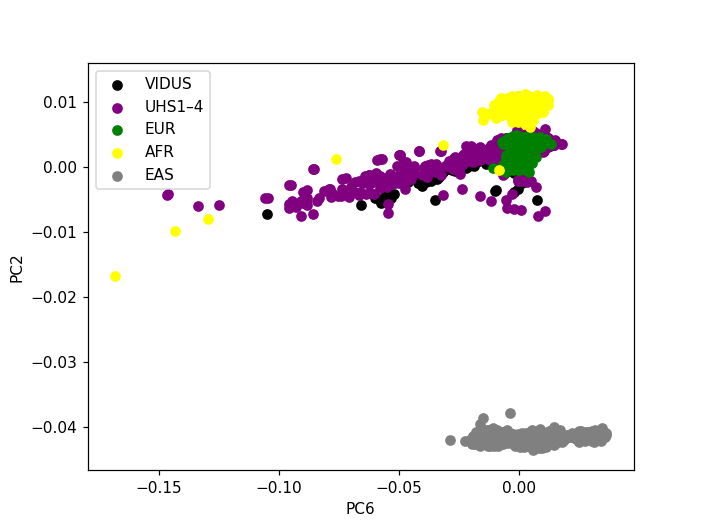

<IPython.core.display.Javascript object>


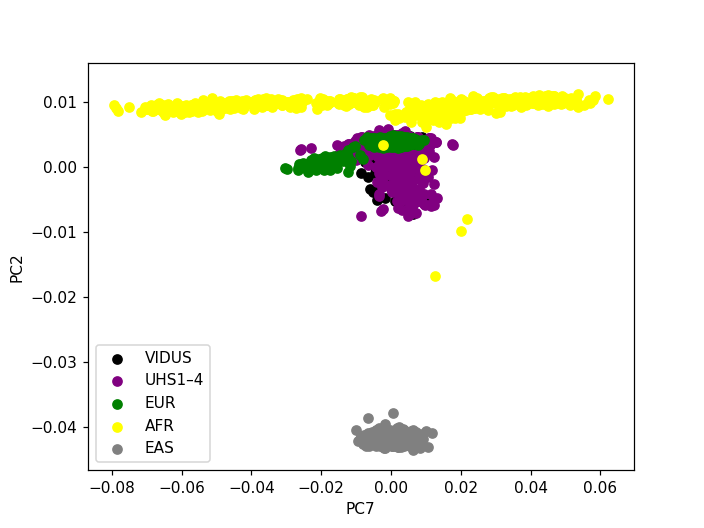

<IPython.core.display.Javascript object>


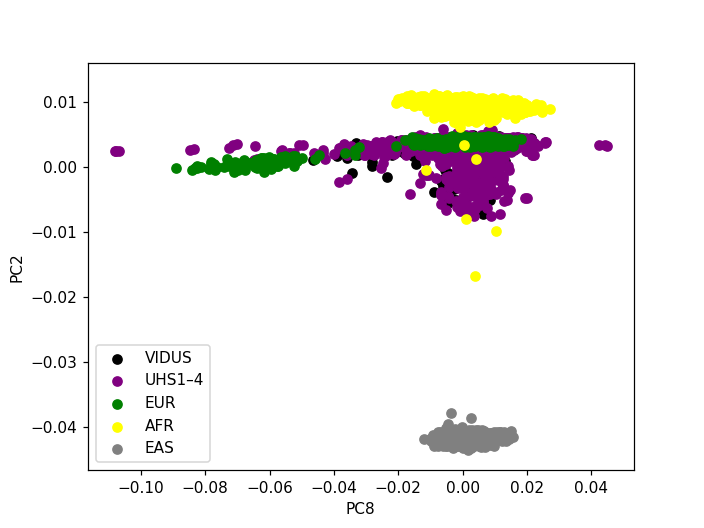

<IPython.core.display.Javascript object>


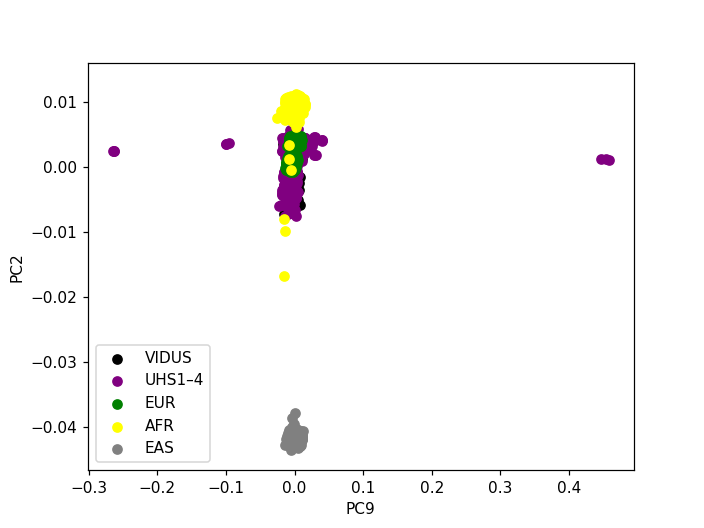

<IPython.core.display.Javascript object>


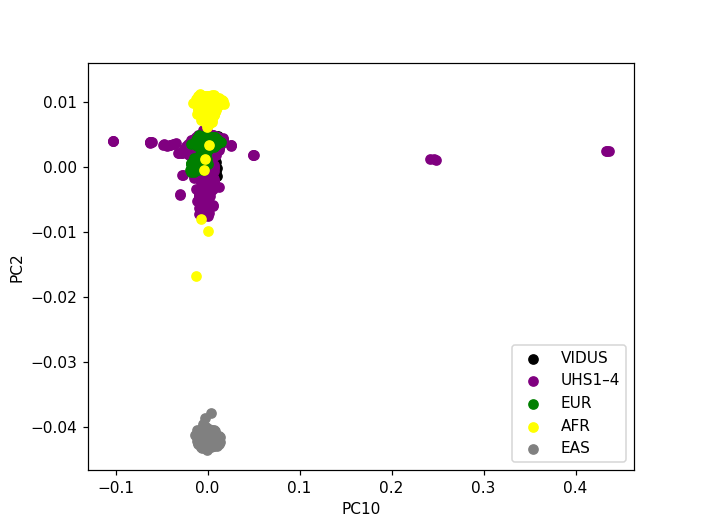

In [27]:
#plot_pc("PC1", "PC2", vidus, "VIDUS", "black")
#plot_pc("PC1", "PC2", uhs, "UHS1–4", "orange")
#plot_pc("PC1", "PC2", eur, "EUR", "green")

pc1 = "PC1"
pc2 = "PC2"


for pc in range(1,11):
    pc1= "PC{}".format(pc)
    multi_plot(plot_num=pc, pc1=pc1, pc2=pc2)

In [4]:
%matplotlib notebook

<IPython.core.display.Javascript object>


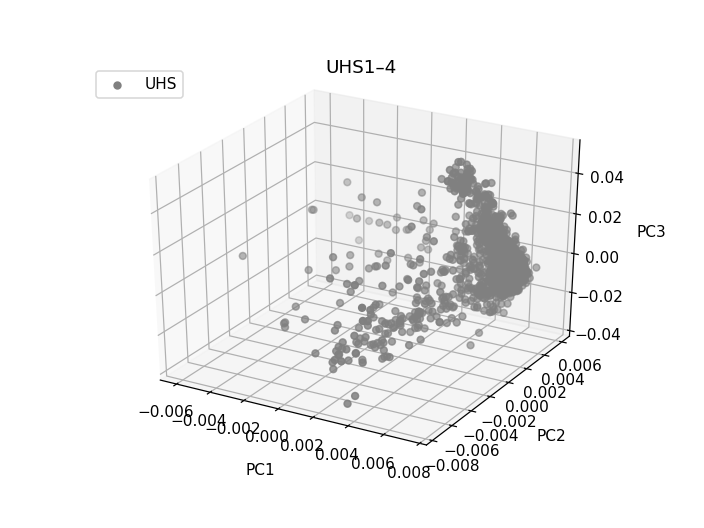

In [53]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#mytit = "PCA: VIDUS, UHS1–4, & 1000G"
mytit = "UHS1–4"
pc1 = "PC1"
pc2 = "PC2"
pc3 = "PC3"

## VIDUS
#x= vidus[pc1]
#y= vidus[pc2]
#z = vidus[pc3]
#ax.scatter(x, y, z, color="blue", label="VIDUS")

## EUR
#x= eur[pc1]
#y= eur[pc2]
#z = eur[pc3]
#ax.scatter(x, y, z, cmap="hsv",color = "red", label="EUR")
#
## AFR
#x= afr[pc1]
#y= afr[pc2]
#z = afr[pc3]
#ax.scatter(x, y, z, cmap="hsv",color = "orange", label="AFR")
#
## EAS
#x= eas[pc1]
#y= eas[pc2]
#z = eas[pc3]
#ax.scatter(x, y, z, cmap="hsv",color = "green", label="AFR")
#
# UHS1–4
x= uhs[pc1]
y= uhs[pc2]
z = uhs[pc3]
ax.scatter(x, y, z, cmap="hsv", color="grey", label="UHS")


ax.legend(loc=2)
ax.set_xlabel(pc1, labelpad=10)
ax.set_ylabel(pc2, labelpad=10)
ax.set_zlabel(pc3, labelpad=10)
plt.title(mytit, pad=15)

plt.show()


# Sandbox
Flip WIHS

In [ ]:
mkdir ${base_dir}/combined/002

## create merge list (note we are not including WIHS)
touch ${base_dir}/combined/002/study_merge_list.txt
echo -e "${base_dir}/1000g/1000g.chr_all.ld_pruned" >>\
    ${base_dir}/combined/002/study_merge_list.txt
echo -e "${base_dir}/vidus/vidus_all_overlap" >>\
    ${base_dir}/combined/002/study_merge_list.txt
echo "${base_dir}/uhs1234_ea/uhs1234_all_overlap" >>\
    ${base_dir}/combined/002/study_merge_list.txt
echo "${base_dir}/wihs_ea/wihs_all_overlap" >>\
    ${base_dir}/combined/002/study_merge_list.txt

## Attempt merge 1000g with study data
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --merge-list ${base_dir}/combined/002/study_merge_list.txt \
    --snps-only just-acgt \
    --make-bed \
    --out ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged
#Error: 7500 variants with 3+ alleles present!


# try flipping the variants in WIHS then retry merge
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile ${base_dir}/wihs_ea/wihs_all_overlap \
    --flip ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged-merge.missnp \
    --make-bed \
    --out ${base_dir}/wihs_ea/wihs_all_overlap_flipped


## create merge list (note we are not including WIHS)
touch ${base_dir}/combined/002/study_merge_list.txt
echo -e "${base_dir}/1000g/1000g.chr_all.ld_pruned" >>\
    ${base_dir}/combined/002/study_merge_list.txt
echo -e "${base_dir}/vidus/vidus_all_overlap" >>\
    ${base_dir}/combined/002/study_merge_list.txt
echo "${base_dir}/uhs1234_ea/uhs1234_all_overlap" >>\
    ${base_dir}/combined/002/study_merge_list.txt
echo "${base_dir}/wihs_ea/wihs_all_overlap_flipped" >>\
    ${base_dir}/combined/002/study_merge_list.txt

## Attempt merge 1000g with study data
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --merge-list ${base_dir}/combined/002/study_merge_list.txt \
    --snps-only just-acgt \
    --make-bed \
    --out ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged
#"""Error: 5 variants with 3+ alleles present."""


## Exclude ambiguous snps (polymorphic) from study data
# VIDUS
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ${base_dir}/vidus/vidus_all_overlap \
    --exclude  ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged-merge.missnp \
    --make-bed \
    --out ${base_dir}/vidus/vidus_all_overlap_removed_5missnp

# WIHS
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ${base_dir}/wihs_ea/wihs_all_overlap_flipped \
    --exclude  ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged-merge.missnp \
    --make-bed \
    --out ${base_dir}/wihs_ea/wihs_all_overlap_flipped_removed_5missnp

# UHS
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ${base_dir}/uhs1234_ea/uhs1234_all_overlap \
    --exclude  ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged-merge.missnp \
    --make-bed \
    --out ${base_dir}/uhs1234_ea/uhs1234_all_overlap_removed_5missnp

# 1000G
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ${base_dir}/1000g/1000g.chr_all.ld_pruned \
    --exclude  ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged-merge.missnp \
    --make-bed \
    --out ${base_dir}/1000g/1000g.chr_all.ld_pruned_removed_5missnp

## create new merge list 
touch ${base_dir}/combined/002/study_merge_list2.txt
echo -e "${base_dir}/1000g/1000g.chr_all.ld_pruned_removed_5missnp" >>\
    ${base_dir}/combined/002/study_merge_list2.txt
echo -e "${base_dir}/vidus/vidus_all_overlap_removed_5missnp" >>\
    ${base_dir}/combined/002/study_merge_list2.txt
echo "${base_dir}/uhs1234_ea/uhs1234_all_overlap_removed_5missnp" >>\
    ${base_dir}/combined/002/study_merge_list2.txt
echo "${base_dir}/wihs_ea/wihs_all_overlap_flipped_removed_5missnp" >>\
    ${base_dir}/combined/002/study_merge_list2.txt

## retry merge
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --merge-list ${base_dir}/combined/002/study_merge_list2.txt \
    --snps-only just-acgt \
    --make-bed \
    --out ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged
# No issues
#"""46251 variants loaded from .bim file.
#7188 people (2356 males, 1500 females, 3332 ambiguous) loaded from .fam.
#"""

## Get 1000G superpopulation subject IDs by ancestry
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="European"){print $1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > ${base_dir}/combined/002/1000g_subject_IDs.EUR
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="African"){print $1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > ${base_dir}/combined/002/1000g_subject_IDs.AFR
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="East Asian"){print $1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > ${base_dir}/combined/002/1000g_subject_IDs.EAS

## exclude all other IDS except EUR, AFR, & EAS group, and VIDUS and UHS
cd ${base_dir}/combined/002
paste *EUR *EUR > keep_ids
paste *AFR *AFR >> keep_ids
paste *EAS *EAS >> keep_ids
cut -d " "  -f1,2 ${base_dir}/vidus/ea_chr_all.fam >> keep_ids
cut -d " "  -f1,2 ${base_dir}/uhs1234_ea/ea_studies_merged.fam >> keep_ids
cut -d " "  -f1,2 ${base_dir}/wihs_ea/wihs.ea.1000g.fam >> keep_ids
"""
ww keep_ids
6988 keep_ids
"""

/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged \
    --keep keep_ids \
    --snps-only just-acgt \
    --make-bed \
    --out ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged.removed_other_ancestries
"""46251 variants and 6352 people pass filters and QC."""

## Rename subject IDs if they are too long
awk '{ if(length($1)+length($2)>39){print $2} }' ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged.removed_other_ancestries.fam | wc -l
# 2834, therefore we will rename the IDs

awk '{$1="ID_"NR; $2="ID_"NR; print $0}' ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged.removed_other_ancestries.fam >\
    ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged.removed_other_ancestries.renamed.fam

awk '{ if(length($1)+length($2)>39){print $2} }' ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged.removed_other_ancestries.renamed.fam | wc -l
# 0


## Run smartpca ##
mkdir ${base_dir}/results/002

sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name vidus.uhs.wihs.1KG.smartpca \
    --script_prefix ${base_dir}/results/002/smartpca \
    --mem 13.5 \
    --nslots 7 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged.removed_other_ancestries.bed \
        -a ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged.removed_other_ancestries.bim \
        -b ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged.removed_other_ancestries.renamed.fam \
        -o ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.pca \
        -p ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.plot \
        -e ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.eval \
        -l ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.pca.log \
        -m 0

## determine which ids are for which cohorts
awk '{$1="ID_"NR; print $0}' ${base_dir}/combined/002/vidus.uhs.wihs.1000g.merged.removed_other_ancestries.fam >\
    ${base_dir}/combined/002/partial.renamed.fam
"""
ww partial.renamed.fam
6352 partial.renamed.fam
"""
cut -d " "  -f1 ${base_dir}/vidus/ea_chr_all.fam > ${base_dir}/combined/002/vidus.fam.ids
cut -d " "  -f1 ${base_dir}/uhs1234_ea/uhs1234_rsid.fam > ${base_dir}/combined/002/uhs.fam.ids
cut -d " "  -f1 ${base_dir}/wihs_ea/wihs_rsid.fam > ${base_dir}/combined/002/wihs.fam.ids

# 1000G
grep -f 1000g_subject_IDs.EUR ${base_dir}/combined/002/partial.renamed.fam |\
    cut -d " " -f1 > ${base_dir}/combined/002/1000g.EUR.fam.ids.final
grep -f 1000g_subject_IDs.EAS ${base_dir}/combined/002/partial.renamed.fam |\
    cut -d " " -f1 > ${base_dir}/combined/002/1000g.EAS.fam.ids.final
grep -f 1000g_subject_IDs.AFR ${base_dir}/combined/002/partial.renamed.fam |\
    cut -d " " -f1 > ${base_dir}/combined/002/1000g.AFR.fam.ids.final

# VIDUS
grep -f ${base_dir}/combined/002/vidus.fam.ids ${base_dir}/combined/002/partial.renamed.fam |\
    cut -d " " -f1 > ${base_dir}/combined/002/vidus.fam.ids.final
# lookup results
awk 'NR==FNR {map[$1]=1;next } \
        {split($1,a,":")} \
        {if(map[a[1]]==1) {print $0}}' \
        ${base_dir}/combined/002/uhs.fam.ids.final \
        ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.pca.evec >\
        ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.pca.evec.VIDUS 

# UHS
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name uhs_fam_ids \
    --script_prefix ${base_dir}/results/002/smartpca \
    --mem 10 \
    --nslots 3 \
    --priority 0 \
    --program "grep -f ${base_dir}/combined/002/uhs.fam.ids ${base_dir}/combined/002/partial.renamed.fam |\
    cut -d\" \" -f1 > ${base_dir}/combined/002/uhs.fam.ids.final"

# lookup results
awk 'NR==FNR {map[$1]=1;next } \
        {split($1,a,":")} \
        {if(map[a[1]]==1) {print $0}}' \
        ${base_dir}/combined/002/uhs.fam.ids.final \
        ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.pca.evec >\
        ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.pca.evec.UHS 


# WIHS
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name wihs_fam_ids \
    --script_prefix ${base_dir}/results/002/wihs \
    --mem 10 \
    --nslots 3 \
    --priority 0 \
    --program "grep -f ${base_dir}/combined/002/wihs.fam.ids ${base_dir}/combined/002/partial.renamed.fam |\
    cut -d\" \" -f1 > ${base_dir}/combined/002/wihs.fam.ids.final"

# lookup results
awk 'NR==FNR {map[$1]=1;next } \
        {split($1,a,":")} \
        {if(map[a[1]]==1) {print $0}}' \
        ${base_dir}/combined/002/1000g.EUR.fam.ids.final \
        ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.pca.evec >\
        ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.pca.evec.WIHS 

# 1KG EUR
awk 'NR==FNR {map[$1]=1;next } \
        {split($1,a,":")} \
        {if(map[a[1]]==1) {print $0}}' \
        ${base_dir}/combined/002/1000g.EAS.fam.ids.final \
        ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.pca.evec >\
        ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.pca.evec.EAS
# 1KG EAS
awk 'NR==FNR {map[$1]=1;next } \
        {split($1,a,":")} \
        {if(map[a[1]]==1) {print $0}}' \
        ${base_dir}/combined/002/1000g.EAS.fam.ids.final \
        ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.pca.evec >\
        ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.pca.evec.EAS 
# 1KG AFR
awk 'NR==FNR {map[$1]=1;next } \
        {split($1,a,":")} \
        {if(map[a[1]]==1) {print $0}}' \
        ${base_dir}/combined/002/1000g.AFR.fam.ids.final \
        ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.pca.evec >\
        ${base_dir}/results/002/vidus.uhs.wihs.1000g.ld_pruned.pca.evec.AFR 

In [ ]:
## download to local
cd /cygdrive/c/Users/jmarks/Desktop/Projects/HIV/vidus/troubleshooting/pca/20190625
scp -i ~/.ssh/gwas_rsa ec2-user@34.206.166.72:/shared/jmarks/sandbox/vidus_troubleshoot/results/002/*evec* .
"""
vidus.uhs.wihs.1000g.ld_pruned.pca.evec                                                                              100%  974KB   4.0MB/s   00:00
vidus.uhs.wihs.1000g.ld_pruned.pca.evec.AFR                                                                          100%  101KB   2.9MB/s   00:00
vidus.uhs.wihs.1000g.ld_pruned.pca.evec.EAS                                                                          100%   77KB   2.4MB/s   00:00
vidus.uhs.wihs.1000g.ld_pruned.pca.evec.EUR                                                                          100%   77KB   2.3MB/s   00:00
vidus.uhs.wihs.1000g.ld_pruned.pca.evec.UHS                                                                          100%  463KB   5.9MB/s   00:00
vidus.uhs.wihs.1000g.ld_pruned.pca.evec.VIDUS                                                                        100%  144KB   4.2MB/s   00:00
vidus.uhs.wihs.1000g.ld_pruned.pca.evec.WIHS                                                                         100%  110KB   3.4MB/s   00:00
"""

### PCA plot in python

In [1]:
import pandas as pd
import matplotlib.pyplot as mpl

import os

os.chdir("/Users/jmarks/OneDrive - Research Triangle Institute/Projects//HIV/vidus/troubleshooting/pca/20190625")
r = os.listdir()
print(r)

def read_evec(file):
    df = pd.read_csv(file, header=None, index_col=0, sep='\s+')
    df.columns = ["PC{}".format(i) for i in range(1, 12)]
    df.index.name = "subjects"
    return df

def plot_pc(pc1, pc2, df, group, color):
    mpl.scatter(x=df[pc1], y=df[pc2], color=color, label=group)
    mpl.legend()
    mpl.xlabel(pc1)
    mpl.ylabel(pc2)


def multi_plot(plot_num, pc1, pc2):
    mpl.figure(plot_num)
    plot_pc(pc1, pc2, vidus, "VIDUS", "black")
    plot_pc(pc1, pc2, uhs, "UHS1–4", "purple")
    plot_pc(pc1, pc2, eur, "EUR", "green")
    plot_pc(pc1, pc2, afr, "AFR", "yellow")
    plot_pc(pc1, pc2, eas, "EAS", "grey")
    plot_pc(pc1, pc2, vidus, "WIHS", "brown")
    

wihs = read_evec(file="vidus.uhs.wihs.1000g.ld_pruned.pca.evec.WIHS")
uhs = read_evec(file="vidus.uhs.wihs.1000g.ld_pruned.pca.evec.UHS")
vidus = read_evec(file="vidus.uhs.wihs.1000g.ld_pruned.pca.evec.VIDUS")
eur = read_evec(file="vidus.uhs.wihs.1000g.ld_pruned.pca.evec.EUR")
afr = read_evec(file="vidus.uhs.wihs.1000g.ld_pruned.pca.evec.AFR")
eas = read_evec(file="vidus.uhs.wihs.1000g.ld_pruned.pca.evec.EAS")

print(wihs.tail())
print(uhs.tail())
print(vidus.tail())
print(afr.tail())
print(eur.tail())
print(eas.tail())


['vidus.uhs.wihs.1000g.ld_pruned.pca.evec', 'vidus.uhs.wihs.1000g.ld_pruned.pca.evec.AFR', 'vidus.uhs.wihs.1000g.ld_pruned.pca.evec.EAS', 'vidus.uhs.wihs.1000g.ld_pruned.pca.evec.EUR', 'vidus.uhs.wihs.1000g.ld_pruned.pca.evec.UHS', 'vidus.uhs.wihs.1000g.ld_pruned.pca.evec.VIDUS', 'vidus.uhs.wihs.1000g.ld_pruned.pca.evec.WIHS']
                    PC1     PC2     PC3     PC4     PC5     PC6     PC7  \
subjects                                                                  
ID_4680:ID_4680 -0.0037  0.0003 -0.0362  0.0085 -0.0189 -0.0013  0.0000   
ID_4681:ID_4681  0.0049  0.0030  0.0037 -0.0001 -0.0009 -0.0034 -0.0011   
ID_4682:ID_4682  0.0052  0.0028  0.0037  0.0026 -0.0001  0.0011  0.0030   
ID_4683:ID_4683  0.0018  0.0033 -0.0015  0.0078 -0.0040 -0.0022  0.0024   
ID_4684:ID_4684  0.0035  0.0024 -0.0115 -0.0123  0.0074 -0.0024  0.0083   

                    PC8     PC9    PC10 PC11  
subjects                                      
ID_4680:ID_4680  0.0006 -0.0009  0.0035  ???  
ID_4

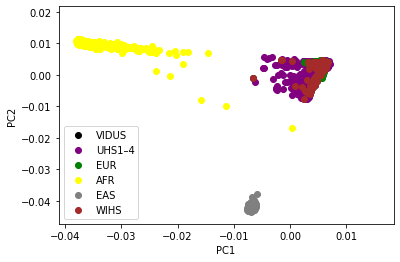

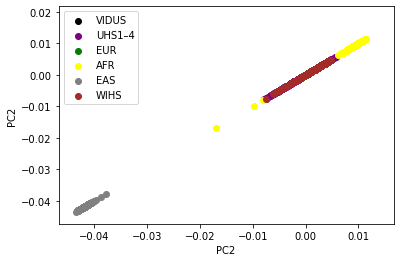

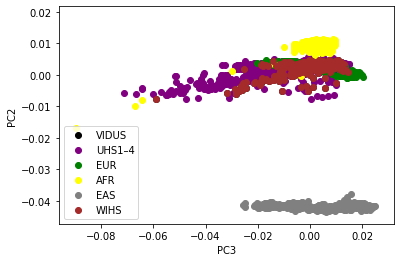

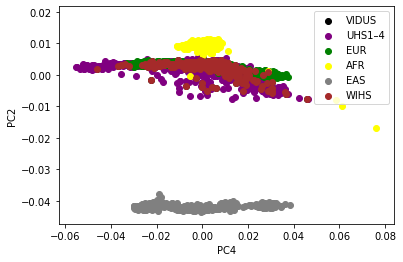

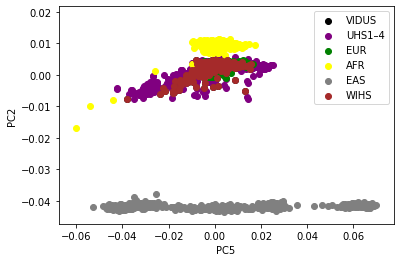

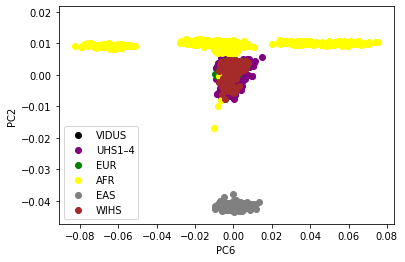

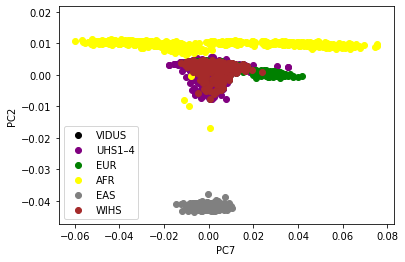

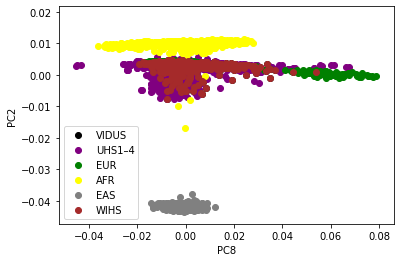

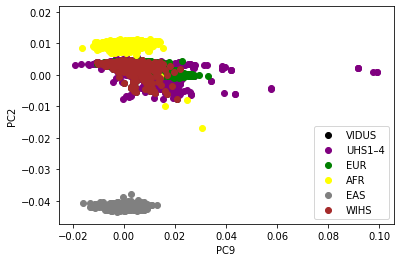

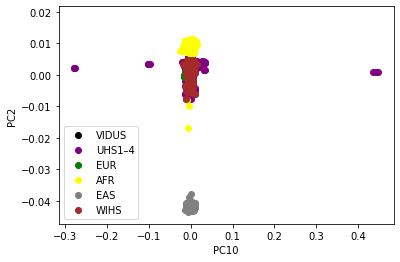

In [8]:
#plot_pc("PC1", "PC2", vidus, "VIDUS", "black")
#plot_pc("PC1", "PC2", uhs, "UHS1–4", "orange")
#plot_pc("PC1", "PC2", eur, "EUR", "green")

pc1 = "PC1"
pc2 = "PC2"


for pc in range(1,11):
    pc1= "PC{}".format(pc)
    multi_plot(plot_num=pc, pc1=pc1, pc2=pc2)

In [2]:
%matplotlib notebook

<IPython.core.display.Javascript object>


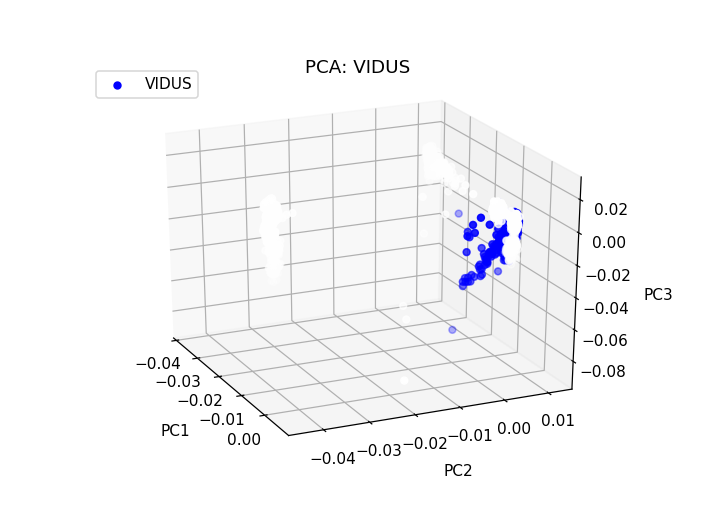

In [42]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#mytit = "PCA: VIDUS, UHS1–4, WIHS, & 1000G"
mytit = "PCA: VIDUS "
pc1 = "PC1"
pc2 = "PC2"
pc3 = "PC3"

## VIDUS
x= vidus[pc1]
y= vidus[pc2]
z = vidus[pc3]
ax.scatter(x, y, z, color="blue", label="VIDUS")

## EUR
x= eur[pc1]
y= eur[pc2]
z = eur[pc3]
#ax.scatter(x, y, z, cmap="hsv",color = "red", label="EUR")
ax.scatter(x, y, z, cmap="hsv",color = "white")

## AFR
x= afr[pc1]
y= afr[pc2]
z = afr[pc3]
#ax.scatter(x, y, z, cmap="hsv",color = "orange", label="AFR")
ax.scatter(x, y, z, cmap="hsv",color = "white")

## EAS
x= eas[pc1]
y= eas[pc2]
z = eas[pc3]
#ax.scatter(x, y, z, cmap="hsv",color = "green", label="EAS")
ax.scatter(x, y, z, cmap="hsv",color = "white")

# UHS1–4
#x= uhs[pc1]
#y= uhs[pc2]
#z = uhs[pc3]
#ax.scatter(x, y, z, cmap="hsv", color="grey", label="UHS")

# WIHS
#x= wihs[pc1]
#y= wihs[pc2]
#z = wihs[pc3]
#ax.scatter(x, y, z, cmap="hsv", color="brown", label="WIHS")

ax.legend(loc=2)
ax.set_xlabel(pc1, labelpad=10)
ax.set_ylabel(pc2, labelpad=10)
ax.set_zlabel(pc3, labelpad=10)
plt.title(mytit, pad=15)

plt.show()
